# Cylcoid Fitting

## Load Cyloid Data Points and Bezier Curves

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import StressTools as tools
import utils
import fitting
import cycloidData
from scipy import stats

interior = utils.import_interior('interior1')

TOLERANCE = 1

cycloids = cycloidData.loadAllCycloids()

min_vals = np.array([0, 0.1, 0])
max_vals = np.array([360, 1, 360])
constraints = [
    dict(wrapValue=True, minValue=1e-8, maxValue=1),
    dict(minValue=1e-8, maxValue=1, unstick=True),
    dict(wrapValue=True, minValue=0, maxValue=1)
]

tight_obliquity_contstraints = [
        dict(wrapValue=True, minValue=1e-8, maxValue=1),
        dict(minValue=0.66, maxValue=0.7, unstick=True),
        dict(wrapValue=True, minValue=0, maxValue=1)
    ]

def getConstraints(obliquity):
    return [
        dict(wrapValue=True, minValue=1e-8, maxValue=1),
        dict(minValue=obliquity, maxValue=obliquity, unstick=False),
        dict(wrapValue=True, minValue=0, maxValue=1)
    ]


### Helper Functions

In [2]:
def translate_params(params, minVals, maxVals):
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    return variables

def setChartXLimit(points, plt):
    BUFFER_PERCENT = 0.025
    
    first = points['lon'].max()
    last = points['lon'].min()
    
    buffer = (first - last) * BUFFER_PERCENT
    
    plt.xlim(first + buffer, last - buffer)


def check_fit(params, minVals, maxVals, curve, interior, tolerance=0.25, title=''):
    
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    plt.figure()
    plt.title(f'{title} - Orientation Match')
    data = fitting.match_stresses(curve, variables, interior)
    fit_points = data.loc[data['deltaHeading'] < tolerance].copy()
    
    if len(variables) >= 3:
        fit_points['lon'] = fit_points['lon'] - variables[2]
    
    plt.plot(curve['lon'], curve['lat'])
    setChartXLimit(curve, plt)
    
    plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')
    
    plt.figure()
    plt.title(f'{title} - Stress Magnitude')
    plt.scatter(fit_points['pointNumber'], fit_points['stress'])
    
    print(np.array(variables))
    return data

def plot_time(data):
    timeData = data.copy()
    time = np.array(timeData['time'])
    time[time < 180] = time[time < 180] + 360
    timeData['time'] = time

    plt.figure()
    plt.scatter(timeData['pointNumber'], timeData['time'],s=1)
    plt.title("Time")

def analyze_fit(opt, curve, tolerance, name=''):
    plt.figure()
    plt.title('Optimizer Loss Values')
    plt.plot(opt[0])

    display(opt[1])
    display(opt[2])

    params = opt[1]['parameters']
    bestCase = check_fit(params, min_vals, max_vals, curve, interior, tolerance=tolerance, 
                         title=f'{name} Best Fit')

    params = opt[2]['parameters']
    finalCase = check_fit(params, min_vals, max_vals, curve, interior, tolerance=tolerance,
                         title=f'{name} Final Fit')


    # Plot time progression
    plot_time(bestCase)
    
    return bestCase, finalCase

def direct_fit(curve, tolerance):
    data = fitting.match_stresses(curve, [0, 0, 0], interior)
    fit_points = data.loc[data['deltaHeading'] < tolerance].copy()
    
    plt.figure()
    plt.plot(curve['lon'], curve['lat'])
    setChartXLimit(curve, plt)
    
    plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')
    plt.figure()
    plt.scatter(fit_points['pointNumber'], fit_points['stress'])
    
    plot_time(data)
    
    return data

def process_cycloid(curve, 
                    name, 
                    folder='./output/', 
                    iterations=500, 
                    constraints=tight_obliquity_contstraints):
    
    numParams = 2
    start_params = [np.random.rand() for iter in range(numParams)]
    start_params[1] = 0.67

    optimizer = fitting.Adam(alpha=0.05)

    opt = optimizer.minimize(
        fitting.test_stress_parameters, 
        curve, 
        start_params, 
        interior,
        constraints=constraints,
        max_iterations=iterations,
        verbose=False,
        batch_size=16
    )

    bestFit, finalFit = analyze_fit(opt, curve, 0.25)

    cols = ['loss', 'phase', 'obliquity']
    df = pd.DataFrame(opt[3], columns=cols).copy()

    df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
    df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

    df.to_csv(f'{folder}{name}Fits.gz', index=False, encoding='utf-8', compression='gzip')
    bestFit.to_csv(f'{folder}{name}BestFit.gz', index=False, encoding='utf-8', compression='gzip') 

## Perform Fits

### Delphi

In [6]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.564134  , 0.48922702]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['delphi'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=2000,
    verbose=False,
    batch_size=16
)

Iteration 50/2000 -- Loss Output: 0.06239743215737046 -- Moving Avg Loss: 0.06071050845233868
	Parameters used: [0.52496409 0.09451128]
Iteration 100/2000 -- Loss Output: 0.0715149547509204 -- Moving Avg Loss: 0.06511524860915308
	Parameters used: [0.74735679 0.74807781]
Iteration 150/2000 -- Loss Output: 0.06083526077412458 -- Moving Avg Loss: 0.06423096842624344
	Parameters used: [0.09116153 0.09058255]
Iteration 200/2000 -- Loss Output: 0.06390019517082335 -- Moving Avg Loss: 0.06206196988624071
	Parameters used: [0.30372579 0.35559887]
Iteration 250/2000 -- Loss Output: 0.06559504074382673 -- Moving Avg Loss: 0.06715384883739006
	Parameters used: [0.50495952 0.21646994]
Iteration 300/2000 -- Loss Output: 0.0655901251861042 -- Moving Avg Loss: 0.06400341703448789
	Parameters used: [0.57184048 0.50797965]
Iteration 350/2000 -- Loss Output: 0.06078924880781755 -- Moving Avg Loss: 0.06770989243151862
	Parameters used: [0.77523991 0.53694124]
Iteration 400/2000 -- Loss Output: 0.0522724

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['delphi'].curve, 0.05, name="Delphi")

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['delphi'].curve, 0.05)

### Tyrrel

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
# start_params = [0.82787206, 0.35201265, 0.78423926]
# start_params = [0.221, 0.558]
# start_params = [0.12218236, 0.62424572]
start_params = [0.221, 0.65011694]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['tyrrel'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=120,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['tyrrel'].curve, 0.05, name="Tyrrel")

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['tyrrel'].curve, 0.25)

### Alex

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.76006373, 0.76072924]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['alex'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=100,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['alex'].curve, 0.05, name='Alex')

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['alex'].curve, 0.25)

### Sidon

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.29055019, 0.18657021]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['sidon'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=100,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['sidon'].curve, 0.05, name='Sidon')

### Carly

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['carly'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=100,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['carly'].curve, 0.05, name='Carly')

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['carly'].curve, 0.25)

### Dirk

In [81]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['dirk'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 9.32377713460903 -- Moving Avg Loss: 9.32377713460903
	Parameters used: [0.8827331186657361, 0.8562027935776152]
Iteration 2/3000 -- Loss Output: 10.088255482543987 -- Moving Avg Loss: 9.706016308576508
	Parameters used: [0.83273312 0.80620279]
Iteration 3/3000 -- Loss Output: 12.444553252171328 -- Moving Avg Loss: 10.618861956441448
	Parameters used: [0.7954257  0.76889226]
Iteration 4/3000 -- Loss Output: 10.987504834795274 -- Moving Avg Loss: 10.711022676029906
	Parameters used: [0.75370063 0.7271657 ]
Iteration 5/3000 -- Loss Output: 10.348450583463473 -- Moving Avg Loss: 10.63850825751662
	Parameters used: [0.70884233 0.68230645]
Iteration 6/3000 -- Loss Output: 13.29768141814607 -- Moving Avg Loss: 11.081703784288194
	Parameters used: [0.66261136 0.63607502]
Iteration 7/3000 -- Loss Output: 14.813214809630681 -- Moving Avg Loss: 11.61477678790855
	Parameters used: [0.6203254  0.59378912]
Iteration 8/3000 -- Loss Output: 10.929425815470267 -- Movin

Iteration 63/3000 -- Loss Output: 1.75975929824463 -- Moving Avg Loss: 0.535806964255951
	Parameters used: [0.08871566 0.06217925]
Iteration 64/3000 -- Loss Output: 1.3055095436734123 -- Moving Avg Loss: 0.5761160411491827
	Parameters used: [0.08225494 0.05571851]
Iteration 65/3000 -- Loss Output: 2.7154530742545804 -- Moving Avg Loss: 0.673082709351688
	Parameters used: [0.07585821 0.04932174]
Iteration 66/3000 -- Loss Output: 4.975056764677973 -- Moving Avg Loss: 0.858846261413174
	Parameters used: [0.0698672  0.04333071]
Iteration 67/3000 -- Loss Output: 2.5174363308287124 -- Moving Avg Loss: 0.9500508830793837
	Parameters used: [0.05039104 0.02385446]
Iteration 68/3000 -- Loss Output: 5.57185354516594 -- Moving Avg Loss: 1.1611830901211193
	Parameters used: [0.03268519 0.00614853]
Iteration 69/3000 -- Loss Output: 15.038701149989317 -- Moving Avg Loss: 1.7487565237671538
	Parameters used: [0.01584256 0.9889287 ]
Iteration 70/3000 -- Loss Output: 13.749367090485766 -- Moving Avg Los

Iteration 124/3000 -- Loss Output: 0.13995586463315438 -- Moving Avg Loss: 0.3418694653353694
	Parameters used: [0.24627471 0.2096095 ]
Iteration 125/3000 -- Loss Output: 0.11930337225041703 -- Moving Avg Loss: 0.34278737970318923
	Parameters used: [0.24545467 0.20877591]
Iteration 126/3000 -- Loss Output: 0.641224928647321 -- Moving Avg Loss: 0.36416900916736755
	Parameters used: [0.24471092 0.20801987]
Iteration 127/3000 -- Loss Output: 0.16073133774584933 -- Moving Avg Loss: 0.36745412414745826
	Parameters used: [0.24399801 0.20729512]
Iteration 128/3000 -- Loss Output: 0.13368493273786794 -- Moving Avg Loss: 0.3318719840139009
	Parameters used: [0.24335092 0.20663727]
Iteration 129/3000 -- Loss Output: 0.10356935134881794 -- Moving Avg Loss: 0.33306221112667395
	Parameters used: [0.24274332 0.20601955]
Iteration 130/3000 -- Loss Output: 0.2122210479477031 -- Moving Avg Loss: 0.3378476849299083
	Parameters used: [0.24219159 0.20545862]
Iteration 131/3000 -- Loss Output: 0.1243539199

Iteration 185/3000 -- Loss Output: 0.14471024805084942 -- Moving Avg Loss: 0.4388266762774441
	Parameters used: [0.19842179 0.16093402]
Iteration 186/3000 -- Loss Output: 0.17492099183877358 -- Moving Avg Loss: 0.44059511390709977
	Parameters used: [0.1975437  0.16004075]
Iteration 187/3000 -- Loss Output: 0.15169604615717305 -- Moving Avg Loss: 0.44142158620389466
	Parameters used: [0.19672711 0.15921005]
Iteration 188/3000 -- Loss Output: 0.20981955597339752 -- Moving Avg Loss: 0.4451570483238622
	Parameters used: [0.19598152 0.15845158]
Iteration 189/3000 -- Loss Output: 0.18550394381016025 -- Moving Avg Loss: 0.448464134804603
	Parameters used: [0.19527459 0.15773244]
Iteration 190/3000 -- Loss Output: 1.9923465861939609 -- Moving Avg Loss: 0.4675639660432167
	Parameters used: [0.1946216  0.15706817]
Iteration 191/3000 -- Loss Output: 0.14253975773718253 -- Moving Avg Loss: 0.46736805479830446
	Parameters used: [0.19366099 0.15609096]
Iteration 192/3000 -- Loss Output: 0.1895334172

Iteration 246/3000 -- Loss Output: 12.944463200289647 -- Moving Avg Loss: 13.410229232301878
	Parameters used: [0.68305045 0.0896309 ]
Iteration 247/3000 -- Loss Output: 16.968516482523096 -- Moving Avg Loss: 13.855534908189252
	Parameters used: [0.66201269 0.06825297]
Iteration 248/3000 -- Loss Output: 7.622194076870425 -- Moving Avg Loss: 13.834052043478877
	Parameters used: [0.6418644  0.04777871]
Iteration 249/3000 -- Loss Output: 16.97354173664272 -- Moving Avg Loss: 14.204864390563344
	Parameters used: [0.62279095 0.02839656]
Iteration 250/3000 -- Loss Output: 11.87671544899976 -- Moving Avg Loss: 14.297474220893424
	Parameters used: [0.60431544 0.00962188]
Iteration 251/3000 -- Loss Output: 12.111335456433697 -- Moving Avg Loss: 14.468067473722359
	Parameters used: [0.58736227 0.37865199]
Iteration 252/3000 -- Loss Output: 12.074857969650617 -- Moving Avg Loss: 14.587551214625185
	Parameters used: [0.57197879 0.36311634]
Iteration 253/3000 -- Loss Output: 8.387569633547377 -- Mo

Iteration 307/3000 -- Loss Output: 0.8346807957035659 -- Moving Avg Loss: 0.7313818376800384
	Parameters used: [0.29688898 0.08402773]
Iteration 308/3000 -- Loss Output: 0.17392645371052248 -- Moving Avg Loss: 0.6862196512054859
	Parameters used: [0.29564014 0.0827583 ]
Iteration 309/3000 -- Loss Output: 0.12460800700576202 -- Moving Avg Loss: 0.6492413574117635
	Parameters used: [0.29450149 0.08160089]
Iteration 310/3000 -- Loss Output: 0.24946530576597487 -- Moving Avg Loss: 0.6534707647533406
	Parameters used: [0.29347003 0.08055244]
Iteration 311/3000 -- Loss Output: 0.21292891643129963 -- Moving Avg Loss: 0.6552963297573008
	Parameters used: [0.29252831 0.07959521]
Iteration 312/3000 -- Loss Output: 0.12616609600606082 -- Moving Avg Loss: 0.5778556095683958
	Parameters used: [0.29166358 0.07871625]
Iteration 313/3000 -- Loss Output: 0.1816121663422341 -- Moving Avg Loss: 0.5805375702017527
	Parameters used: [0.29086725 0.07790682]
Iteration 314/3000 -- Loss Output: 0.6088045635193

Iteration 368/3000 -- Loss Output: 0.31523136440928123 -- Moving Avg Loss: 0.6625344798114138
	Parameters used: [0.22430664 0.01027047]
Iteration 369/3000 -- Loss Output: 0.3424480988760985 -- Moving Avg Loss: 0.6433399895961527
	Parameters used: [0.21911041 0.0049906 ]
Iteration 370/3000 -- Loss Output: 0.31263416043106224 -- Moving Avg Loss: 0.5758836471689057
	Parameters used: [0.21441711 0.00022176]
Iteration 371/3000 -- Loss Output: 0.08025729109562582 -- Moving Avg Loss: 0.5697457430536226
	Parameters used: [0.21016157 0.94562437]
Iteration 372/3000 -- Loss Output: 0.09208429953179438 -- Moving Avg Loss: 0.5629707990955294
	Parameters used: [0.2063225  0.94172647]
Iteration 373/3000 -- Loss Output: 0.08069786969525303 -- Moving Avg Loss: 0.5590200738304065
	Parameters used: [0.20286137 0.93821228]
Iteration 374/3000 -- Loss Output: 0.08195620011439096 -- Moving Avg Loss: 0.5538339535789865
	Parameters used: [0.19974025 0.93504333]
Iteration 375/3000 -- Loss Output: 0.069184278601

Iteration 429/3000 -- Loss Output: 0.1382137353639464 -- Moving Avg Loss: 0.3337409356888799
	Parameters used: [0.14196538 0.8763518 ]
Iteration 430/3000 -- Loss Output: 0.1801499090851631 -- Moving Avg Loss: 0.3361791164638122
	Parameters used: [0.14124636 0.87562118]
Iteration 431/3000 -- Loss Output: 0.8412015406192527 -- Moving Avg Loss: 0.3655184870097397
	Parameters used: [0.14049718 0.87485992]
Iteration 432/3000 -- Loss Output: 0.9672413250075549 -- Moving Avg Loss: 0.3992022894838311
	Parameters used: [0.1397681  0.87411909]
Iteration 433/3000 -- Loss Output: 0.560401301469138 -- Moving Avg Loss: 0.41665582812214935
	Parameters used: [0.13903764 0.87337685]
Iteration 434/3000 -- Loss Output: 0.1548374473954056 -- Moving Avg Loss: 0.39899808498270034
	Parameters used: [0.13833824 0.87266618]
Iteration 435/3000 -- Loss Output: 0.4090591044598056 -- Moving Avg Loss: 0.40445271980943226
	Parameters used: [0.13766799 0.87198511]
Iteration 436/3000 -- Loss Output: 0.1686111336063413

Iteration 490/3000 -- Loss Output: 2.298436065754477 -- Moving Avg Loss: 0.7735576774721917
	Parameters used: [0.07264256 0.80591129]
Iteration 491/3000 -- Loss Output: 2.9312414299638254 -- Moving Avg Loss: 0.874022900698208
	Parameters used: [0.07029399 0.80352487]
Iteration 492/3000 -- Loss Output: 4.131378065927776 -- Moving Avg Loss: 1.023579897688143
	Parameters used: [0.06808046 0.80127565]
Iteration 493/3000 -- Loss Output: 11.711279759073436 -- Moving Avg Loss: 1.4844831690914888
	Parameters used: [0.06607812 0.79924104]
Iteration 494/3000 -- Loss Output: 13.747553523753673 -- Moving Avg Loss: 1.978890624830808
	Parameters used: [0.06434772 0.79748274]
Iteration 495/3000 -- Loss Output: 15.50651069245632 -- Moving Avg Loss: 2.5881456174544963
	Parameters used: [0.06228512 0.7953869 ]
Iteration 496/3000 -- Loss Output: 16.76761660947799 -- Moving Avg Loss: 3.2474536158392233
	Parameters used: [0.05764751 0.79067459]
Iteration 497/3000 -- Loss Output: 14.413318425797828 -- Movin

Iteration 551/3000 -- Loss Output: 4.847478915226921 -- Moving Avg Loss: 1.0175173082979705
	Parameters used: [0.06535265 0.35167243]
Iteration 552/3000 -- Loss Output: 3.7232286579126432 -- Moving Avg Loss: 1.15640260134185
	Parameters used: [0.06369905 0.35000236]
Iteration 553/3000 -- Loss Output: 5.856365137163759 -- Moving Avg Loss: 1.3798121241716583
	Parameters used: [0.06216771 0.34845586]
Iteration 554/3000 -- Loss Output: 6.28099809188734 -- Moving Avg Loss: 1.6228406243918854
	Parameters used: [0.06075043 0.34702463]
Iteration 555/3000 -- Loss Output: 8.651268879811786 -- Moving Avg Loss: 1.958652509063975
	Parameters used: [0.05633121 0.34256853]
Iteration 556/3000 -- Loss Output: 15.923495984783797 -- Moving Avg Loss: 2.579709574330955
	Parameters used: [0.05234047 0.33854447]
Iteration 557/3000 -- Loss Output: 12.318435269396087 -- Moving Avg Loss: 3.047887128992204
	Parameters used: [0.04875608 0.33493017]
Iteration 558/3000 -- Loss Output: 13.069705677287763 -- Moving A

Iteration 612/3000 -- Loss Output: 0.07403334142074978 -- Moving Avg Loss: 0.2961609442412888
	Parameters used: [0.3642092  0.42932131]
Iteration 613/3000 -- Loss Output: 0.2429164207763828 -- Moving Avg Loss: 0.3001871281880526
	Parameters used: [0.3629219  0.42803356]
Iteration 614/3000 -- Loss Output: 0.0676234779793757 -- Moving Avg Loss: 0.2204529384490478
	Parameters used: [0.36175956 0.42687077]
Iteration 615/3000 -- Loss Output: 0.06949067562922404 -- Moving Avg Loss: 0.21703469544252207
	Parameters used: [0.36071018 0.42582095]
Iteration 616/3000 -- Loss Output: 0.05782246846828228 -- Moving Avg Loss: 0.16134517615874103
	Parameters used: [0.35976272 0.42487307]
Iteration 617/3000 -- Loss Output: 0.07330513557158348 -- Moving Avg Loss: 0.12466360996731622
	Parameters used: [0.35890848 0.42401843]
Iteration 618/3000 -- Loss Output: 0.06885995200463015 -- Moving Avg Loss: 0.12415078787675973
	Parameters used: [0.35813827 0.42324786]
Iteration 619/3000 -- Loss Output: 0.051842434

Iteration 672/3000 -- Loss Output: 0.08094887968518129 -- Moving Avg Loss: 0.17486392178106022
	Parameters used: [0.33819171 0.4031391 ]
Iteration 673/3000 -- Loss Output: 0.07018974351764577 -- Moving Avg Loss: 0.17450312661710754
	Parameters used: [0.33775237 0.40269593]
Iteration 674/3000 -- Loss Output: 0.07594024848503544 -- Moving Avg Loss: 0.17500644637592455
	Parameters used: [0.33735188 0.40229195]
Iteration 675/3000 -- Loss Output: 0.07795944884942634 -- Moving Avg Loss: 0.1753180051769707
	Parameters used: [0.33699078 0.4019277 ]
Iteration 676/3000 -- Loss Output: 0.0933953630442542 -- Moving Avg Loss: 0.17593896921917382
	Parameters used: [0.33666187 0.40159592]
Iteration 677/3000 -- Loss Output: 0.09506719956330527 -- Moving Avg Loss: 0.17729831965337367
	Parameters used: [0.33636527 0.40129674]
Iteration 678/3000 -- Loss Output: 0.08324144529698149 -- Moving Avg Loss: 0.17803059817691302
	Parameters used: [0.33607901 0.40100798]
Iteration 679/3000 -- Loss Output: 0.065805

Iteration 733/3000 -- Loss Output: 0.06717528667500826 -- Moving Avg Loss: 0.18814100877645834
	Parameters used: [0.32206401 0.38687079]
Iteration 734/3000 -- Loss Output: 0.07649179298480972 -- Moving Avg Loss: 0.18909686474945667
	Parameters used: [0.32124941 0.38604907]
Iteration 735/3000 -- Loss Output: 0.06241818210289321 -- Moving Avg Loss: 0.18844384505758213
	Parameters used: [0.32051373 0.38530699]
Iteration 736/3000 -- Loss Output: 0.09102314107034243 -- Moving Avg Loss: 0.1893417401187515
	Parameters used: [0.3198492  0.38463666]
Iteration 737/3000 -- Loss Output: 1.0583914295358754 -- Moving Avg Loss: 0.22798094475883005
	Parameters used: [0.31924974 0.38403197]
Iteration 738/3000 -- Loss Output: 0.07347579789144708 -- Moving Avg Loss: 0.19851026703139657
	Parameters used: [0.31669963 0.38145964]
Iteration 739/3000 -- Loss Output: 0.060604508886468324 -- Moving Avg Loss: 0.15804468011669162
	Parameters used: [0.31439971 0.37913967]
Iteration 740/3000 -- Loss Output: 1.31402

Iteration 794/3000 -- Loss Output: 0.07008803788533419 -- Moving Avg Loss: 0.21572580340807185
	Parameters used: [0.28204947 0.34650742]
Iteration 795/3000 -- Loss Output: 0.07878704347016871 -- Moving Avg Loss: 0.21552169394105097
	Parameters used: [0.28173474 0.34618996]
Iteration 796/3000 -- Loss Output: 0.08397321364796886 -- Moving Avg Loss: 0.21490579402964724
	Parameters used: [0.28144929 0.34590202]
Iteration 797/3000 -- Loss Output: 0.09883504403002573 -- Moving Avg Loss: 0.21605201076832473
	Parameters used: [0.28118848 0.34563893]
Iteration 798/3000 -- Loss Output: 0.297266776945402 -- Moving Avg Loss: 0.224464972891383
	Parameters used: [0.28095206 0.34540045]
Iteration 799/3000 -- Loss Output: 0.07752527326382759 -- Moving Avg Loss: 0.18518159804686593
	Parameters used: [0.279347  0.3437814]
Iteration 800/3000 -- Loss Output: 0.08980516843908702 -- Moving Avg Loss: 0.1866647121397016
	Parameters used: [0.27789983 0.34232161]
Iteration 801/3000 -- Loss Output: 0.06297913991

Iteration 855/3000 -- Loss Output: 0.10530446036852813 -- Moving Avg Loss: 0.16963823323279617
	Parameters used: [0.25109294 0.31528106]
Iteration 856/3000 -- Loss Output: 0.08402635651225819 -- Moving Avg Loss: 0.16934039703160464
	Parameters used: [0.25081101 0.31499667]
Iteration 857/3000 -- Loss Output: 0.0943423549680147 -- Moving Avg Loss: 0.16960102833338803
	Parameters used: [0.25051658 0.31469967]
Iteration 858/3000 -- Loss Output: 0.09090282658551634 -- Moving Avg Loss: 0.16952560045304846
	Parameters used: [0.25023992 0.3144206 ]
Iteration 859/3000 -- Loss Output: 0.129038064645226 -- Moving Avg Loss: 0.16997481415034954
	Parameters used: [0.24998489 0.31416335]
Iteration 860/3000 -- Loss Output: 0.07417986354840866 -- Moving Avg Loss: 0.1687895720878007
	Parameters used: [0.24975267 0.3139291 ]
Iteration 861/3000 -- Loss Output: 0.0879674407198064 -- Moving Avg Loss: 0.16877277444734465
	Parameters used: [0.24953139 0.3137059 ]
Iteration 862/3000 -- Loss Output: 1.162975515

Iteration 916/3000 -- Loss Output: 0.08234206159442134 -- Moving Avg Loss: 0.10028088180066604
	Parameters used: [0.23492105 0.29896821]
Iteration 917/3000 -- Loss Output: 0.12127603755230555 -- Moving Avg Loss: 0.10206655088792692
	Parameters used: [0.23461638 0.29866088]
Iteration 918/3000 -- Loss Output: 0.10764526973834015 -- Moving Avg Loss: 0.10211716443656133
	Parameters used: [0.23433837 0.29838044]
Iteration 919/3000 -- Loss Output: 0.1270464983985426 -- Moving Avg Loss: 0.10168087289038832
	Parameters used: [0.23407938 0.2981192 ]
Iteration 920/3000 -- Loss Output: 0.1278214352194241 -- Moving Avg Loss: 0.10290076460603555
	Parameters used: [0.23112511 0.29513919]
Iteration 921/3000 -- Loss Output: 0.13895913189568038 -- Moving Avg Loss: 0.1048029037092111
	Parameters used: [0.22846345 0.29245434]
Iteration 922/3000 -- Loss Output: 0.11957337893537469 -- Moving Avg Loss: 0.10575378614071732
	Parameters used: [0.22606508 0.29003507]
Iteration 923/3000 -- Loss Output: 0.1156311

Iteration 977/3000 -- Loss Output: 0.14336645355594219 -- Moving Avg Loss: 0.24557080220265548
	Parameters used: [0.18660458 0.25023072]
Iteration 978/3000 -- Loss Output: 0.17688526430912757 -- Moving Avg Loss: 0.2470695746531436
	Parameters used: [0.18619369 0.24981626]
Iteration 979/3000 -- Loss Output: 0.14011333261532177 -- Moving Avg Loss: 0.2450100308617461
	Parameters used: [0.18581009 0.24942932]
Iteration 980/3000 -- Loss Output: 0.11896784335785834 -- Moving Avg Loss: 0.2193037280420645
	Parameters used: [0.18545444 0.24907057]
Iteration 981/3000 -- Loss Output: 0.19186804291051204 -- Moving Avg Loss: 0.22078528512917456
	Parameters used: [0.18511731 0.2487305 ]
Iteration 982/3000 -- Loss Output: 0.15706557268160753 -- Moving Avg Loss: 0.22197605134000523
	Parameters used: [0.18480508 0.24841554]
Iteration 983/3000 -- Loss Output: 0.13703092774129028 -- Moving Avg Loss: 0.20626298429893436
	Parameters used: [0.18450409 0.24811193]
Iteration 984/3000 -- Loss Output: 0.1124645

Iteration 1038/3000 -- Loss Output: 0.3596560599173513 -- Moving Avg Loss: 0.5377594939631639
	Parameters used: [0.12277294 0.18584313]
Iteration 1039/3000 -- Loss Output: 0.3092331926706926 -- Moving Avg Loss: 0.5418906496370686
	Parameters used: [0.12089545 0.18394929]
Iteration 1040/3000 -- Loss Output: 0.3791446354584065 -- Moving Avg Loss: 0.544274413601464
	Parameters used: [0.11919422 0.18223325]
Iteration 1041/3000 -- Loss Output: 0.5682713314461499 -- Moving Avg Loss: 0.5142956647337945
	Parameters used: [0.11765467 0.1806803 ]
Iteration 1042/3000 -- Loss Output: 0.3607177764232527 -- Moving Avg Loss: 0.5194194717583681
	Parameters used: [0.11623889 0.1792522 ]
Iteration 1043/3000 -- Loss Output: 0.3648886360019638 -- Moving Avg Loss: 0.5265767992904626
	Parameters used: [0.11495233 0.17795443]
Iteration 1044/3000 -- Loss Output: 0.48787684825726724 -- Moving Avg Loss: 0.5372252347420853
	Parameters used: [0.11378204 0.17677396]
Iteration 1045/3000 -- Loss Output: 0.3386156534

Iteration 1099/3000 -- Loss Output: 12.679656580359376 -- Moving Avg Loss: 4.939443312145008
	Parameters used: [0.0144366  0.07656383]
Iteration 1100/3000 -- Loss Output: 8.56585515524836 -- Moving Avg Loss: 5.264422911954086
	Parameters used: [0.01013543 0.07222525]
Iteration 1101/3000 -- Loss Output: 12.342097915352001 -- Moving Avg Loss: 5.71820819368657
	Parameters used: [0.00607808 0.0681326 ]
Iteration 1102/3000 -- Loss Output: 13.326481825822617 -- Moving Avg Loss: 6.205110924747025
	Parameters used: [0.99068571 0.05260739]
Iteration 1103/3000 -- Loss Output: 13.511961062921445 -- Moving Avg Loss: 6.709347484658488
	Parameters used: [0.97682366 0.0385302 ]
Iteration 1104/3000 -- Loss Output: 10.708872658533245 -- Moving Avg Loss: 7.056455710064548
	Parameters used: [0.96433872 0.02585148]
Iteration 1105/3000 -- Loss Output: 15.489095139234388 -- Moving Avg Loss: 7.6138909113045585
	Parameters used: [0.95292406 0.01426198]
Iteration 1106/3000 -- Loss Output: 12.80620460841855 -- 

Iteration 1160/3000 -- Loss Output: 0.05492091822196311 -- Moving Avg Loss: 0.15979488898934932
	Parameters used: [0.36183918 0.65531825]
Iteration 1161/3000 -- Loss Output: 0.05388886401379797 -- Moving Avg Loss: 0.1575197337841355
	Parameters used: [0.36092697 0.6544026 ]
Iteration 1162/3000 -- Loss Output: 0.044390368449959305 -- Moving Avg Loss: 0.09886277076854118
	Parameters used: [0.36010447 0.65357698]
Iteration 1163/3000 -- Loss Output: 0.030861696754438027 -- Moving Avg Loss: 0.09615628461212765
	Parameters used: [0.35936272 0.65283241]
Iteration 1164/3000 -- Loss Output: 0.054511723841084186 -- Moving Avg Loss: 0.09585974104208343
	Parameters used: [0.35723393 0.65068222]
Iteration 1165/3000 -- Loss Output: 0.04346744737069394 -- Moving Avg Loss: 0.08329399395483472
	Parameters used: [0.35531557 0.64874458]
Iteration 1166/3000 -- Loss Output: 0.05706944068533059 -- Moving Avg Loss: 0.08329470413494916
	Parameters used: [0.35358723 0.64699888]
Iteration 1167/3000 -- Loss Outp

Iteration 1220/3000 -- Loss Output: 0.04211838291716567 -- Moving Avg Loss: 0.06859952446937662
	Parameters used: [0.33346061 0.62668055]
Iteration 1221/3000 -- Loss Output: 0.14964864546872103 -- Moving Avg Loss: 0.07213993729166647
	Parameters used: [0.33333784 0.62655677]
Iteration 1222/3000 -- Loss Output: 0.05093397908882646 -- Moving Avg Loss: 0.07190973346385779
	Parameters used: [0.3332238  0.62644177]
Iteration 1223/3000 -- Loss Output: 0.05943270069954639 -- Moving Avg Loss: 0.07218463223515494
	Parameters used: [0.33310127 0.62631822]
Iteration 1224/3000 -- Loss Output: 0.04234218612122154 -- Moving Avg Loss: 0.07183062435123205
	Parameters used: [0.33295729 0.62617303]
Iteration 1225/3000 -- Loss Output: 0.04941892349194974 -- Moving Avg Loss: 0.07145228754291823
	Parameters used: [0.33278293 0.62599722]
Iteration 1226/3000 -- Loss Output: 0.05559085554112223 -- Moving Avg Loss: 0.07195406738489568
	Parameters used: [0.33262473 0.62583771]
Iteration 1227/3000 -- Loss Output

Iteration 1280/3000 -- Loss Output: 0.055358832638457894 -- Moving Avg Loss: 0.05516230413324217
	Parameters used: [0.31757143 0.61065877]
Iteration 1281/3000 -- Loss Output: 0.035562793081554675 -- Moving Avg Loss: 0.054498341147147585
	Parameters used: [0.31740709 0.61049307]
Iteration 1282/3000 -- Loss Output: 0.047755045302162485 -- Moving Avg Loss: 0.05424605939483441
	Parameters used: [0.31725577 0.61034048]
Iteration 1283/3000 -- Loss Output: 0.04456485983779494 -- Moving Avg Loss: 0.053869901409970104
	Parameters used: [0.3171175  0.61020106]
Iteration 1284/3000 -- Loss Output: 0.048623302307841794 -- Moving Avg Loss: 0.0534751488407881
	Parameters used: [0.31698634 0.6100688 ]
Iteration 1285/3000 -- Loss Output: 0.04803234480205006 -- Moving Avg Loss: 0.05330586811677992
	Parameters used: [0.31685602 0.60993739]
Iteration 1286/3000 -- Loss Output: 0.04077800544204767 -- Moving Avg Loss: 0.052693765830427654
	Parameters used: [0.3167185  0.60979873]
Iteration 1287/3000 -- Loss 

Iteration 1340/3000 -- Loss Output: 0.07039323914886925 -- Moving Avg Loss: 0.056252389663150076
	Parameters used: [0.30625635 0.59924926]
Iteration 1341/3000 -- Loss Output: 0.058234476527576406 -- Moving Avg Loss: 0.05625784631631626
	Parameters used: [0.30608197 0.59907343]
Iteration 1342/3000 -- Loss Output: 0.038043575626890425 -- Moving Avg Loss: 0.05569103859801136
	Parameters used: [0.30590483 0.59889481]
Iteration 1343/3000 -- Loss Output: 0.05568760282073872 -- Moving Avg Loss: 0.055724302738217456
	Parameters used: [0.30574155 0.59873017]
Iteration 1344/3000 -- Loss Output: 0.06186007005382667 -- Moving Avg Loss: 0.05577764124891588
	Parameters used: [0.30559437 0.59858175]
Iteration 1345/3000 -- Loss Output: 0.0567476706056889 -- Moving Avg Loss: 0.05599235895978593
	Parameters used: [0.30546107 0.59844734]
Iteration 1346/3000 -- Loss Output: 0.05972829308362701 -- Moving Avg Loss: 0.05613530340120874
	Parameters used: [0.30533547 0.5983207 ]
Iteration 1347/3000 -- Loss Out

Iteration 1400/3000 -- Loss Output: 0.06137618194858763 -- Moving Avg Loss: 0.058868596611259656
	Parameters used: [0.29524559 0.58814661]
Iteration 1401/3000 -- Loss Output: 0.06216177746608461 -- Moving Avg Loss: 0.058729364098167626
	Parameters used: [0.29510593 0.58800579]
Iteration 1402/3000 -- Loss Output: 0.04289309607224901 -- Moving Avg Loss: 0.05809456523102265
	Parameters used: [0.29497315 0.5878719 ]
Iteration 1403/3000 -- Loss Output: 0.04969126903510807 -- Moving Avg Loss: 0.05776519606326346
	Parameters used: [0.29469616 0.5875926 ]
Iteration 1404/3000 -- Loss Output: 0.06448000822888245 -- Moving Avg Loss: 0.0576784944658559
	Parameters used: [0.29444481 0.58733915]
Iteration 1405/3000 -- Loss Output: 0.05202777473794846 -- Moving Avg Loss: 0.05769337814972701
	Parameters used: [0.29421736 0.5871098 ]
Iteration 1406/3000 -- Loss Output: 0.058241602676223685 -- Moving Avg Loss: 0.057755149304683624
	Parameters used: [0.29400697 0.58689765]
Iteration 1407/3000 -- Loss Out

Iteration 1460/3000 -- Loss Output: 0.05324492647471576 -- Moving Avg Loss: 0.06047518165170715
	Parameters used: [0.26048408 0.5530951 ]
Iteration 1461/3000 -- Loss Output: 0.06846015185803189 -- Moving Avg Loss: 0.060912326089299945
	Parameters used: [0.26013412 0.55274222]
Iteration 1462/3000 -- Loss Output: 0.06106640115235875 -- Moving Avg Loss: 0.061046249598003616
	Parameters used: [0.25979551 0.55240078]
Iteration 1463/3000 -- Loss Output: 0.059027901173087996 -- Moving Avg Loss: 0.06143411340418797
	Parameters used: [0.25941862 0.55202075]
Iteration 1464/3000 -- Loss Output: 0.06880194182100116 -- Moving Avg Loss: 0.06211459831421724
	Parameters used: [0.25907888 0.55167817]
Iteration 1465/3000 -- Loss Output: 0.04977886194180149 -- Moving Avg Loss: 0.061940785387997466
	Parameters used: [0.25877089 0.55136761]
Iteration 1466/3000 -- Loss Output: 0.06776039178190087 -- Moving Avg Loss: 0.061967952921208797
	Parameters used: [0.25848445 0.55107878]
Iteration 1467/3000 -- Loss O

Iteration 1520/3000 -- Loss Output: 0.06859994741161483 -- Moving Avg Loss: 0.11828781531190907
	Parameters used: [0.24093408 0.53338197]
Iteration 1521/3000 -- Loss Output: 0.29219378181325023 -- Moving Avg Loss: 0.12694371266668203
	Parameters used: [0.24068728 0.53313312]
Iteration 1522/3000 -- Loss Output: 0.06979245220740352 -- Moving Avg Loss: 0.12623944737024448
	Parameters used: [0.24044793 0.53289177]
Iteration 1523/3000 -- Loss Output: 0.5554658652827699 -- Moving Avg Loss: 0.14600369910888122
	Parameters used: [0.24019884 0.53264061]
Iteration 1524/3000 -- Loss Output: 0.06060706877515409 -- Moving Avg Loss: 0.14581731046880725
	Parameters used: [0.23968515 0.53212263]
Iteration 1525/3000 -- Loss Output: 0.0799735194973676 -- Moving Avg Loss: 0.137888713048996
	Parameters used: [0.23919575 0.53162915]
Iteration 1526/3000 -- Loss Output: 0.069033433341485 -- Moving Avg Loss: 0.13764744390146416
	Parameters used: [0.23875291 0.5311826 ]
Iteration 1527/3000 -- Loss Output: 0.06

Iteration 1580/3000 -- Loss Output: 0.07494503557334885 -- Moving Avg Loss: 0.09067941088765555
	Parameters used: [0.2263378  0.51866391]
Iteration 1581/3000 -- Loss Output: 0.08557413746749586 -- Moving Avg Loss: 0.09112795215505744
	Parameters used: [0.22615175 0.51847631]
Iteration 1582/3000 -- Loss Output: 0.0901355353961889 -- Moving Avg Loss: 0.08158665395393301
	Parameters used: [0.22597715 0.51830026]
Iteration 1583/3000 -- Loss Output: 0.09304872467700157 -- Moving Avg Loss: 0.0825108486956189
	Parameters used: [0.225807   0.51812868]
Iteration 1584/3000 -- Loss Output: 0.07243616290686038 -- Moving Avg Loss: 0.08213277169108103
	Parameters used: [0.22564437 0.5179647 ]
Iteration 1585/3000 -- Loss Output: 0.07153900767722705 -- Moving Avg Loss: 0.08261688673715434
	Parameters used: [0.22548262 0.51780159]
Iteration 1586/3000 -- Loss Output: 0.08097336141715471 -- Moving Avg Loss: 0.08241158207407218
	Parameters used: [0.22533501 0.51765275]
Iteration 1587/3000 -- Loss Output: 

Iteration 1640/3000 -- Loss Output: 0.08607137815140874 -- Moving Avg Loss: 0.12451462214479792
	Parameters used: [0.21016295 0.50235411]
Iteration 1641/3000 -- Loss Output: 0.08043978361183578 -- Moving Avg Loss: 0.12416462115394386
	Parameters used: [0.20988148 0.50207028]
Iteration 1642/3000 -- Loss Output: 0.10530814227926481 -- Moving Avg Loss: 0.12588271698030307
	Parameters used: [0.20962147 0.50180811]
Iteration 1643/3000 -- Loss Output: 0.5486758400466599 -- Moving Avg Loss: 0.14435239291760904
	Parameters used: [0.20938371 0.50156836]
Iteration 1644/3000 -- Loss Output: 0.10240065887675794 -- Moving Avg Loss: 0.1454068072360237
	Parameters used: [0.20905935 0.5012413 ]
Iteration 1645/3000 -- Loss Output: 0.06039881985801162 -- Moving Avg Loss: 0.14456519647983165
	Parameters used: [0.20875515 0.50093456]
Iteration 1646/3000 -- Loss Output: 0.27764722259704594 -- Moving Avg Loss: 0.14707544479593382
	Parameters used: [0.20847169 0.50064874]
Iteration 1647/3000 -- Loss Output: 

Iteration 1700/3000 -- Loss Output: 0.14893033601688258 -- Moving Avg Loss: 0.1557237790903805
	Parameters used: [0.18965306 0.48167309]
Iteration 1701/3000 -- Loss Output: 0.6916350850272547 -- Moving Avg Loss: 0.17955558827293353
	Parameters used: [0.18924061 0.4812572 ]
Iteration 1702/3000 -- Loss Output: 0.10534113297323348 -- Moving Avg Loss: 0.17936862607721557
	Parameters used: [0.18856752 0.48057849]
Iteration 1703/3000 -- Loss Output: 0.10348809326709849 -- Moving Avg Loss: 0.1740615576274542
	Parameters used: [0.18746959 0.4794714 ]
Iteration 1704/3000 -- Loss Output: 0.10304922088662144 -- Moving Avg Loss: 0.1730661495178375
	Parameters used: [0.18645696 0.47845033]
Iteration 1705/3000 -- Loss Output: 0.2833307358399343 -- Moving Avg Loss: 0.18088123591294314
	Parameters used: [0.18553509 0.47752076]
Iteration 1706/3000 -- Loss Output: 0.12362066330776438 -- Moving Avg Loss: 0.1819031457997947
	Parameters used: [0.1846988  0.47667749]
Iteration 1707/3000 -- Loss Output: 0.98

Iteration 1760/3000 -- Loss Output: 0.23285017423540352 -- Moving Avg Loss: 0.2725398296353866
	Parameters used: [0.14574099 0.43739465]
Iteration 1761/3000 -- Loss Output: 0.4669031027917538 -- Moving Avg Loss: 0.28804144429884865
	Parameters used: [0.14492244 0.43656927]
Iteration 1762/3000 -- Loss Output: 0.2176145225497901 -- Moving Avg Loss: 0.2926110456592068
	Parameters used: [0.14415849 0.43579894]
Iteration 1763/3000 -- Loss Output: 0.15713989183684055 -- Moving Avg Loss: 0.2929467085190456
	Parameters used: [0.14343873 0.43507318]
Iteration 1764/3000 -- Loss Output: 0.19839377099319253 -- Moving Avg Loss: 0.2837371495712248
	Parameters used: [0.14239654 0.43402229]
Iteration 1765/3000 -- Loss Output: 0.2299732078204944 -- Moving Avg Loss: 0.28650123372738157
	Parameters used: [0.14145492 0.43307282]
Iteration 1766/3000 -- Loss Output: 1.4720617922609747 -- Moving Avg Loss: 0.34117251280709054
	Parameters used: [0.14056713 0.43217763]
Iteration 1767/3000 -- Loss Output: 0.1784

Iteration 1820/3000 -- Loss Output: 0.5081578422589981 -- Moving Avg Loss: 0.4781838278797046
	Parameters used: [0.09934073 0.39060727]
Iteration 1821/3000 -- Loss Output: 0.4418910369261252 -- Moving Avg Loss: 0.48357854540400746
	Parameters used: [0.09857742 0.38983759]
Iteration 1822/3000 -- Loss Output: 0.4827728001359246 -- Moving Avg Loss: 0.494090905090551
	Parameters used: [0.09783702 0.38909102]
Iteration 1823/3000 -- Loss Output: 0.4403137136525384 -- Moving Avg Loss: 0.4394036561846157
	Parameters used: [0.09713676 0.38838492]
Iteration 1824/3000 -- Loss Output: 1.6060687368108129 -- Moving Avg Loss: 0.4898599287263777
	Parameters used: [0.09647574 0.38771838]
Iteration 1825/3000 -- Loss Output: 1.8442175125124858 -- Moving Avg Loss: 0.5539896646806859
	Parameters used: [0.09572891 0.38696532]
Iteration 1826/3000 -- Loss Output: 1.1574976237862378 -- Moving Avg Loss: 0.591936644604034
	Parameters used: [0.09488968 0.38611909]
Iteration 1827/3000 -- Loss Output: 0.36824401966

Iteration 1881/3000 -- Loss Output: 1.2500016586607754 -- Moving Avg Loss: 2.634919599186371
	Parameters used: [0.29301217 0.09945243]
Iteration 1882/3000 -- Loss Output: 0.14580059937238632 -- Moving Avg Loss: 2.091334176622411
	Parameters used: [0.2893851 0.096188 ]
Iteration 1883/3000 -- Loss Output: 0.15926585032597315 -- Moving Avg Loss: 1.487207953972518
	Parameters used: [0.28610782 0.09323585]
Iteration 1884/3000 -- Loss Output: 0.18506062449141153 -- Moving Avg Loss: 1.1664082487761978
	Parameters used: [0.28315563 0.09057634]
Iteration 1885/3000 -- Loss Output: 0.14961702710675956 -- Moving Avg Loss: 0.5665905054339373
	Parameters used: [0.2804947  0.08817868]
Iteration 1886/3000 -- Loss Output: 0.14803228086130021 -- Moving Avg Loss: 0.555046502955801
	Parameters used: [0.27809699 0.08601786]
Iteration 1887/3000 -- Loss Output: 0.18615693277424186 -- Moving Avg Loss: 0.5452307633779381
	Parameters used: [0.2759372  0.08407131]
Iteration 1888/3000 -- Loss Output: 2.3369868208

Iteration 1942/3000 -- Loss Output: 0.16083368266663636 -- Moving Avg Loss: 0.7058359198439677
	Parameters used: [0.15813775 0.51735156]
Iteration 1943/3000 -- Loss Output: 0.3763761352936055 -- Moving Avg Loss: 0.6819199399370952
	Parameters used: [0.1568455  0.51604898]
Iteration 1944/3000 -- Loss Output: 0.16878360909239065 -- Moving Avg Loss: 0.5792466458228903
	Parameters used: [0.1556603  0.51485431]
Iteration 1945/3000 -- Loss Output: 0.1629850920369852 -- Moving Avg Loss: 0.5375390035209621
	Parameters used: [0.15455618 0.51374132]
Iteration 1946/3000 -- Loss Output: 0.1375923009578301 -- Moving Avg Loss: 0.5339469592880235
	Parameters used: [0.15355571 0.51273283]
Iteration 1947/3000 -- Loss Output: 0.183520576534449 -- Moving Avg Loss: 0.4623045356208026
	Parameters used: [0.15263873 0.51180848]
Iteration 1948/3000 -- Loss Output: 0.11065475729955412 -- Moving Avg Loss: 0.3093191502577992
	Parameters used: [0.15181151 0.51097461]
Iteration 1949/3000 -- Loss Output: 0.15573223

Iteration 2002/3000 -- Loss Output: 0.29121679622232177 -- Moving Avg Loss: 0.4356167099684932
	Parameters used: [0.10868392 0.46748907]
Iteration 2003/3000 -- Loss Output: 0.2283904379008744 -- Moving Avg Loss: 0.43839490227562977
	Parameters used: [0.10788363 0.46668212]
Iteration 2004/3000 -- Loss Output: 0.28795404430065513 -- Moving Avg Loss: 0.4274758110912499
	Parameters used: [0.10585235 0.46463395]
Iteration 2005/3000 -- Loss Output: 0.6565257412287638 -- Moving Avg Loss: 0.4173615590200759
	Parameters used: [0.10401401 0.46278032]
Iteration 2006/3000 -- Loss Output: 0.5721417113843802 -- Moving Avg Loss: 0.4319646781589088
	Parameters used: [0.10235003 0.4611025 ]
Iteration 2007/3000 -- Loss Output: 0.35423839029811666 -- Moving Avg Loss: 0.4384203391797295
	Parameters used: [0.1008265 0.4595663]
Iteration 2008/3000 -- Loss Output: 0.32950159344077534 -- Moving Avg Loss: 0.4432443652280238
	Parameters used: [0.09940448 0.45813245]
Iteration 2009/3000 -- Loss Output: 0.4576179

Iteration 2063/3000 -- Loss Output: 1.319404832841389 -- Moving Avg Loss: 10.435134661222046
	Parameters used: [0.29140657 0.19049785]
Iteration 2064/3000 -- Loss Output: 0.1496338889048252 -- Moving Avg Loss: 9.924805747465472
	Parameters used: [0.26980092 0.16866058]
Iteration 2065/3000 -- Loss Output: 0.28774648399441005 -- Moving Avg Loss: 9.286696687227256
	Parameters used: [0.25034238 0.14899346]
Iteration 2066/3000 -- Loss Output: 0.12542499729613826 -- Moving Avg Loss: 8.73708102257381
	Parameters used: [0.23281962 0.13128287]
Iteration 2067/3000 -- Loss Output: 0.179464384263346 -- Moving Avg Loss: 8.216518941516537
	Parameters used: [0.21703851 0.1153326 ]
Iteration 2068/3000 -- Loss Output: 1.7396262001227394 -- Moving Avg Loss: 7.608928112643972
	Parameters used: [0.20282743 0.10096919]
Iteration 2069/3000 -- Loss Output: 0.2187493049311789 -- Moving Avg Loss: 7.06300446128169
	Parameters used: [0.19001815 0.08802269]
Iteration 2070/3000 -- Loss Output: 0.23869408990324903 

Iteration 2124/3000 -- Loss Output: 0.1344443308587962 -- Moving Avg Loss: 8.062835389404974
	Parameters used: [0.40693621 0.18361425]
Iteration 2125/3000 -- Loss Output: 0.09781874610416454 -- Moving Avg Loss: 7.570509728184718
	Parameters used: [0.39572064 0.17231674]
Iteration 2126/3000 -- Loss Output: 0.14534489660306718 -- Moving Avg Loss: 7.109142821381061
	Parameters used: [0.38561895 0.16214125]
Iteration 2127/3000 -- Loss Output: 0.9472055375800377 -- Moving Avg Loss: 6.757455265027777
	Parameters used: [0.37652155 0.15297739]
Iteration 2128/3000 -- Loss Output: 2.3823983971974054 -- Moving Avg Loss: 6.455360480775503
	Parameters used: [0.3683268  0.14472277]
Iteration 2129/3000 -- Loss Output: 2.371503121890289 -- Moving Avg Loss: 6.12524185133613
	Parameters used: [0.3609334  0.13727535]
Iteration 2130/3000 -- Loss Output: 0.689137747666305 -- Moving Avg Loss: 5.5478629715361105
	Parameters used: [0.35423438 0.13052738]
Iteration 2131/3000 -- Loss Output: 0.11001468091802036

Iteration 2185/3000 -- Loss Output: 0.08749308390969966 -- Moving Avg Loss: 0.7630247968340369
	Parameters used: [0.20447647 0.60540487]
Iteration 2186/3000 -- Loss Output: 0.07778947288870153 -- Moving Avg Loss: 0.67861620389214
	Parameters used: [0.19992737 0.60082373]
Iteration 2187/3000 -- Loss Output: 0.5435672301518671 -- Moving Avg Loss: 0.6936856044648865
	Parameters used: [0.19583053 0.59669802]
Iteration 2188/3000 -- Loss Output: 0.09848714461011639 -- Moving Avg Loss: 0.6919267764780437
	Parameters used: [0.1921026  0.59294381]
Iteration 2189/3000 -- Loss Output: 0.10196146878196248 -- Moving Avg Loss: 0.5735188664230413
	Parameters used: [0.18873856 0.58955605]
Iteration 2190/3000 -- Loss Output: 0.10505684971286879 -- Moving Avg Loss: 0.5306522172074382
	Parameters used: [0.18570879 0.58650492]
Iteration 2191/3000 -- Loss Output: 0.08834081842317121 -- Moving Avg Loss: 0.5274701385478381
	Parameters used: [0.18297965 0.58375653]
Iteration 2192/3000 -- Loss Output: 0.150490

Iteration 2245/3000 -- Loss Output: 0.26168843035171785 -- Moving Avg Loss: 0.2950070259554056
	Parameters used: [0.11304092 0.51330988]
Iteration 2246/3000 -- Loss Output: 0.26286107016031884 -- Moving Avg Loss: 0.2988458428178967
	Parameters used: [0.11235942 0.51262339]
Iteration 2247/3000 -- Loss Output: 0.30603194827069174 -- Moving Avg Loss: 0.3025241887406225
	Parameters used: [0.11174553 0.51200501]
Iteration 2248/3000 -- Loss Output: 0.29977715511704867 -- Moving Avg Loss: 0.30578020691995006
	Parameters used: [0.11115941 0.5114146 ]
Iteration 2249/3000 -- Loss Output: 0.274819953787258 -- Moving Avg Loss: 0.3095941665472725
	Parameters used: [0.11062257 0.51087383]
Iteration 2250/3000 -- Loss Output: 0.3044293798374166 -- Moving Avg Loss: 0.31318543228513585
	Parameters used: [0.11011906 0.51036664]
Iteration 2251/3000 -- Loss Output: 0.24841416634065952 -- Moving Avg Loss: 0.31446157897547566
	Parameters used: [0.10961831 0.50986222]
Iteration 2252/3000 -- Loss Output: 0.255

Iteration 2306/3000 -- Loss Output: 0.3080684152552799 -- Moving Avg Loss: 11.49986934373044
	Parameters used: [0.45968554 0.04078374]
Iteration 2307/3000 -- Loss Output: 0.2048555953700483 -- Moving Avg Loss: 10.882474966240991
	Parameters used: [0.41070303 0.17424104]
Iteration 2308/3000 -- Loss Output: 0.15344477569711912 -- Moving Avg Loss: 10.135192944317176
	Parameters used: [0.36659375 0.1299229 ]
Iteration 2309/3000 -- Loss Output: 0.1574257814044415 -- Moving Avg Loss: 9.388847210248633
	Parameters used: [0.32687332 0.0900144 ]
Iteration 2310/3000 -- Loss Output: 0.1694017485943903 -- Moving Avg Loss: 8.877079000435101
	Parameters used: [0.2911049  0.05407661]
Iteration 2311/3000 -- Loss Output: 0.7095580517376169 -- Moving Avg Loss: 8.205997116467357
	Parameters used: [0.25889524 0.02171444]
Iteration 2312/3000 -- Loss Output: 0.061204598830950134 -- Moving Avg Loss: 7.552395750618314
	Parameters used: [0.22989042 0.78749476]
Iteration 2313/3000 -- Loss Output: 0.075544014988

Iteration 2367/3000 -- Loss Output: 0.0490369280069083 -- Moving Avg Loss: 0.201440719246195
	Parameters used: [0.29821874 0.85364618]
Iteration 2368/3000 -- Loss Output: 0.04733721078939982 -- Moving Avg Loss: 0.09370915762807541
	Parameters used: [0.29668753 0.85216083]
Iteration 2369/3000 -- Loss Output: 0.057806977996619074 -- Moving Avg Loss: 0.04671431633389282
	Parameters used: [0.29530707 0.85082159]
Iteration 2370/3000 -- Loss Output: 0.047177197509724676 -- Moving Avg Loss: 0.045719763039940124
	Parameters used: [0.29406394 0.84961558]
Iteration 2371/3000 -- Loss Output: 0.050205643173239 -- Moving Avg Loss: 0.04562685038361656
	Parameters used: [0.29294324 0.84852824]
Iteration 2372/3000 -- Loss Output: 0.040765863287063 -- Moving Avg Loss: 0.04495868253434889
	Parameters used: [0.29193393 0.84754896]
Iteration 2373/3000 -- Loss Output: 0.04296954089133168 -- Moving Avg Loss: 0.044523035911634645
	Parameters used: [0.29102429 0.84666633]
Iteration 2374/3000 -- Loss Output: 0

Iteration 2427/3000 -- Loss Output: 0.044115909715138096 -- Moving Avg Loss: 0.0478103161522815
	Parameters used: [0.27941152 0.83522156]
Iteration 2428/3000 -- Loss Output: 0.059813512928642135 -- Moving Avg Loss: 0.04820434604157639
	Parameters used: [0.27930189 0.8351109 ]
Iteration 2429/3000 -- Loss Output: 0.04040775166516925 -- Moving Avg Loss: 0.047604321049052344
	Parameters used: [0.27920598 0.83501409]
Iteration 2430/3000 -- Loss Output: 0.03618361209009915 -- Moving Avg Loss: 0.04729345883586044
	Parameters used: [0.27907109 0.83487793]
Iteration 2431/3000 -- Loss Output: 0.03301899905367827 -- Moving Avg Loss: 0.046761424027484004
	Parameters used: [0.27894255 0.83474819]
Iteration 2432/3000 -- Loss Output: 0.050316741421929045 -- Moving Avg Loss: 0.04662119079845208
	Parameters used: [0.27856147 0.83436354]
Iteration 2433/3000 -- Loss Output: 0.04112825267889509 -- Moving Avg Loss: 0.04647925782038908
	Parameters used: [0.27821736 0.83401619]
Iteration 2434/3000 -- Loss Ou

Iteration 2487/3000 -- Loss Output: 0.057697632898774644 -- Moving Avg Loss: 0.0501137403918789
	Parameters used: [0.27032184 0.82604655]
Iteration 2488/3000 -- Loss Output: 0.045707140229349685 -- Moving Avg Loss: 0.04988988413892263
	Parameters used: [0.27013738 0.82586037]
Iteration 2489/3000 -- Loss Output: 0.06336948019974407 -- Moving Avg Loss: 0.05040459452002299
	Parameters used: [0.26995339 0.82567465]
Iteration 2490/3000 -- Loss Output: 0.043670734553080695 -- Moving Avg Loss: 0.050413244528465156
	Parameters used: [0.26978886 0.82550857]
Iteration 2491/3000 -- Loss Output: 0.05553157809103354 -- Moving Avg Loss: 0.05079049259374188
	Parameters used: [0.26963088 0.82534911]
Iteration 2492/3000 -- Loss Output: 0.041227229622803375 -- Moving Avg Loss: 0.05088760054791591
	Parameters used: [0.26948306 0.8251999 ]
Iteration 2493/3000 -- Loss Output: 0.04755571817273872 -- Moving Avg Loss: 0.05040141006432042
	Parameters used: [0.26934009 0.82505559]
Iteration 2494/3000 -- Loss Ou

Iteration 2547/3000 -- Loss Output: 0.06685353900244287 -- Moving Avg Loss: 0.04892265037052264
	Parameters used: [0.25929837 0.81491961]
Iteration 2548/3000 -- Loss Output: 0.05659942586594712 -- Moving Avg Loss: 0.048761642409776006
	Parameters used: [0.25914147 0.81476124]
Iteration 2549/3000 -- Loss Output: 0.06333724905512822 -- Moving Avg Loss: 0.04981019618042525
	Parameters used: [0.2589818  0.81460007]
Iteration 2550/3000 -- Loss Output: 0.0519202551794112 -- Moving Avg Loss: 0.049722598490947505
	Parameters used: [0.25883638 0.81445328]
Iteration 2551/3000 -- Loss Output: 0.05672870164980088 -- Moving Avg Loss: 0.049942327233206435
	Parameters used: [0.25826766 0.81387923]
Iteration 2552/3000 -- Loss Output: 0.0727261603620423 -- Moving Avg Loss: 0.05143554335514735
	Parameters used: [0.25775128 0.813358  ]
Iteration 2553/3000 -- Loss Output: 0.06121735957916955 -- Moving Avg Loss: 0.05190652062590716
	Parameters used: [0.25728631 0.81288867]
Iteration 2554/3000 -- Loss Outpu

Iteration 2607/3000 -- Loss Output: 0.050605461314171485 -- Moving Avg Loss: 0.07368453176430789
	Parameters used: [0.24348542 0.79895823]
Iteration 2608/3000 -- Loss Output: 0.051582597210361264 -- Moving Avg Loss: 0.07371411579523315
	Parameters used: [0.24323456 0.79870501]
Iteration 2609/3000 -- Loss Output: 0.054248819683246394 -- Moving Avg Loss: 0.06753477587701087
	Parameters used: [0.24300553 0.79847383]
Iteration 2610/3000 -- Loss Output: 0.06794898908649456 -- Moving Avg Loss: 0.06784578180412967
	Parameters used: [0.24266378 0.79812888]
Iteration 2611/3000 -- Loss Output: 0.05240475529499766 -- Moving Avg Loss: 0.06823624173049746
	Parameters used: [0.24235176 0.79781393]
Iteration 2612/3000 -- Loss Output: 0.042275131142569984 -- Moving Avg Loss: 0.06756940477164719
	Parameters used: [0.2420627  0.79752216]
Iteration 2613/3000 -- Loss Output: 0.04608632360740219 -- Moving Avg Loss: 0.06305919123919587
	Parameters used: [0.24179973 0.79725672]
Iteration 2614/3000 -- Loss Ou

Iteration 2667/3000 -- Loss Output: 0.0680971511607242 -- Moving Avg Loss: 0.09778275070751162
	Parameters used: [0.22973532 0.78507906]
Iteration 2668/3000 -- Loss Output: 0.052033255706212395 -- Moving Avg Loss: 0.09708448225244531
	Parameters used: [0.22914144 0.78447961]
Iteration 2669/3000 -- Loss Output: 0.06273370488719557 -- Moving Avg Loss: 0.09342306561090095
	Parameters used: [0.22860282 0.78393594]
Iteration 2670/3000 -- Loss Output: 0.12122868503902287 -- Moving Avg Loss: 0.08488610503990096
	Parameters used: [0.22811817 0.78344674]
Iteration 2671/3000 -- Loss Output: 0.06347675823640456 -- Moving Avg Loss: 0.08489729971857843
	Parameters used: [0.22767574 0.78300015]
Iteration 2672/3000 -- Loss Output: 0.2455624188132267 -- Moving Avg Loss: 0.09180031307472468
	Parameters used: [0.22726778 0.78258837]
Iteration 2673/3000 -- Loss Output: 0.30517069110867573 -- Moving Avg Loss: 0.10119948354651029
	Parameters used: [0.22687551 0.78219241]
Iteration 2674/3000 -- Loss Output:

Iteration 2727/3000 -- Loss Output: 0.07557823257617417 -- Moving Avg Loss: 0.12169377685080604
	Parameters used: [0.21491804 0.7701227 ]
Iteration 2728/3000 -- Loss Output: 0.047952918086785264 -- Moving Avg Loss: 0.12070374710155624
	Parameters used: [0.21474312 0.76994613]
Iteration 2729/3000 -- Loss Output: 0.0697564108498561 -- Moving Avg Loss: 0.12089981870150222
	Parameters used: [0.21456939 0.76977077]
Iteration 2730/3000 -- Loss Output: 0.08091523765061609 -- Moving Avg Loss: 0.12132632533756789
	Parameters used: [0.21441067 0.76961056]
Iteration 2731/3000 -- Loss Output: 0.07393532239212858 -- Moving Avg Loss: 0.12163550823869164
	Parameters used: [0.21426556 0.76946409]
Iteration 2732/3000 -- Loss Output: 0.5775872205125918 -- Moving Avg Loss: 0.14241019560158136
	Parameters used: [0.21413011 0.76932738]
Iteration 2733/3000 -- Loss Output: 0.0822146791101177 -- Moving Avg Loss: 0.14213226707802132
	Parameters used: [0.21383128 0.76902574]
Iteration 2734/3000 -- Loss Output: 

Iteration 2787/3000 -- Loss Output: 0.09040753136726125 -- Moving Avg Loss: 0.13387895830510976
	Parameters used: [0.19479466 0.74981043]
Iteration 2788/3000 -- Loss Output: 0.05727108894098013 -- Moving Avg Loss: 0.13323656978161108
	Parameters used: [0.19460772 0.74962173]
Iteration 2789/3000 -- Loss Output: 0.2030812278465009 -- Moving Avg Loss: 0.11482947641363225
	Parameters used: [0.1943765  0.74938835]
Iteration 2790/3000 -- Loss Output: 0.06488623630664474 -- Moving Avg Loss: 0.11436523769969117
	Parameters used: [0.1941044  0.74911369]
Iteration 2791/3000 -- Loss Output: 0.0622366538267048 -- Moving Avg Loss: 0.11419264025890657
	Parameters used: [0.19383943 0.74884623]
Iteration 2792/3000 -- Loss Output: 0.3220675923308901 -- Moving Avg Loss: 0.10512846016902017
	Parameters used: [0.19359451 0.74859901]
Iteration 2793/3000 -- Loss Output: 0.0957421333976264 -- Moving Avg Loss: 0.10648487445049191
	Parameters used: [0.19335048 0.7483527 ]
Iteration 2794/3000 -- Loss Output: 0.

Iteration 2847/3000 -- Loss Output: 0.08845517529642485 -- Moving Avg Loss: 0.24273963636211898
	Parameters used: [0.16548088 0.7202215 ]
Iteration 2848/3000 -- Loss Output: 0.8738594008937061 -- Moving Avg Loss: 0.27476757151334996
	Parameters used: [0.16498132 0.71971726]
Iteration 2849/3000 -- Loss Output: 0.46604728352147523 -- Moving Avg Loss: 0.2893843156565763
	Parameters used: [0.16449059 0.71922192]
Iteration 2850/3000 -- Loss Output: 0.152730643828326 -- Moving Avg Loss: 0.2923206280420675
	Parameters used: [0.16388641 0.71861207]
Iteration 2851/3000 -- Loss Output: 0.24401176381644332 -- Moving Avg Loss: 0.2745273396494645
	Parameters used: [0.16328293 0.71800293]
Iteration 2852/3000 -- Loss Output: 0.11524145574862281 -- Moving Avg Loss: 0.27576081846521044
	Parameters used: [0.16272201 0.71743674]
Iteration 2853/3000 -- Loss Output: 0.13201780445893108 -- Moving Avg Loss: 0.2766504361225428
	Parameters used: [0.16221198 0.71692192]
Iteration 2854/3000 -- Loss Output: 0.102

Iteration 2907/3000 -- Loss Output: 0.17618594780089974 -- Moving Avg Loss: 0.33410587247953466
	Parameters used: [0.12819933 0.68259002]
Iteration 2908/3000 -- Loss Output: 0.18242173718437313 -- Moving Avg Loss: 0.3370097774929435
	Parameters used: [0.12750283 0.68188699]
Iteration 2909/3000 -- Loss Output: 0.22011408210300462 -- Moving Avg Loss: 0.3149352649630991
	Parameters used: [0.12686899 0.6812472 ]
Iteration 2910/3000 -- Loss Output: 0.18082095660509206 -- Moving Avg Loss: 0.3169737734657213
	Parameters used: [0.12628333 0.68065604]
Iteration 2911/3000 -- Loss Output: 1.3933505739012726 -- Moving Avg Loss: 0.3677964632909225
	Parameters used: [0.12569763 0.68006485]
Iteration 2912/3000 -- Loss Output: 0.48684606278737047 -- Moving Avg Loss: 0.3761710947532624
	Parameters used: [0.12515165 0.67951374]
Iteration 2913/3000 -- Loss Output: 0.2311768704303181 -- Moving Avg Loss: 0.37778027690377786
	Parameters used: [0.12451971 0.67887587]
Iteration 2914/3000 -- Loss Output: 0.177

Iteration 2968/3000 -- Loss Output: 0.16379526620879742 -- Moving Avg Loss: 3.440165939903167
	Parameters used: [0.24584961 0.13060348]
Iteration 2969/3000 -- Loss Output: 0.23754221844586929 -- Moving Avg Loss: 3.4316493281330556
	Parameters used: [0.18353423 0.06818759]
Iteration 2970/3000 -- Loss Output: 0.6266147895522548 -- Moving Avg Loss: 3.4254361525796178
	Parameters used: [0.12742074 0.01198359]
Iteration 2971/3000 -- Loss Output: 1.4054242260296934 -- Moving Avg Loss: 3.4622863793426886
	Parameters used: [0.0768916  0.11517314]
Iteration 2972/3000 -- Loss Output: 7.481810040465098 -- Moving Avg Loss: 3.7201563044709642
	Parameters used: [0.03138852 0.06960096]
Iteration 2973/3000 -- Loss Output: 10.645259285280243 -- Moving Avg Loss: 4.115517216691803
	Parameters used: [0.9904138  0.02856401]
Iteration 2974/3000 -- Loss Output: 11.917272358719236 -- Moving Avg Loss: 4.566928519763477
	Parameters used: [0.95351716 0.5585654 ]
Iteration 2975/3000 -- Loss Output: 13.23225725158

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['dirk'].curve, 0.25, name='Dirk')

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['dirk'].curve, 0.25)

### Yaphet

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.29347151, 0.30240127]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['yaphet'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=100,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['yaphet'].curve, 0.25, name='Yaphet')

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['yaphet'].curve, 0.25)

### Odessa

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['odessa'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=100,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['odessa'].curve, 0.25, name='Odessa')

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['odessa'].curve, 0.25)

### Mira

In [ ]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['mira'].curve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=100,
    verbose=True,
    batch_size=16
)

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['mira'].curve, 0.25, name='Mira')

#### Test with no phase

In [ ]:
data = direct_fit(cycloids['mira'].curve, 0.05)

### Cilicia

In [111]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    cycloids['cilicia'].curve, 
    start_params, 
    interior,
    constraints=tight_obliquity_contstraints,
    max_iterations=1500,
    verbose=False,
    batch_size=16
)

Iteration 50/1500 -- Loss Output: 0.07380262340800198 -- Moving Avg Loss: 0.08203844001215624
	Parameters used: [0.96951167 0.68455415]
Iteration 100/1500 -- Loss Output: 0.060848697574181064 -- Moving Avg Loss: 0.06353905943857203
	Parameters used: [0.84933714 0.67566213]
Iteration 150/1500 -- Loss Output: 0.05226903974273151 -- Moving Avg Loss: 0.0555918235245096
	Parameters used: [0.72553357 0.67314348]
Iteration 200/1500 -- Loss Output: 0.06883915910210468 -- Moving Avg Loss: 0.0654129827861367
	Parameters used: [0.61024697 0.68413232]
Iteration 250/1500 -- Loss Output: 0.06479471167226268 -- Moving Avg Loss: 0.1496905077357294
	Parameters used: [0.7787308 0.6696051]
Iteration 300/1500 -- Loss Output: 0.05207262329237751 -- Moving Avg Loss: 0.061348184093970186
	Parameters used: [0.64210949 0.66786245]
Iteration 350/1500 -- Loss Output: 0.05551572898193829 -- Moving Avg Loss: 0.07593442757271968
	Parameters used: [0.46121166 0.66421321]
Iteration 400/1500 -- Loss Output: 0.05764963

In [ ]:
bestFit, finalFit = analyze_fit(opt, cycloids['cilicia'].curve, 0.25, name='Cilicia')

In [ ]:
process_cycloid(ciliciaCurve, 'cilicia', folder='./output/', iterations=3000, constraints=constraints)
process_cycloid(ciliciaCurve, 'cilicia', 
                folder='./output/tightObliquity/', 
                iterations=3000)

## Trying with locked obliquity

In [ ]:
process_cycloid(yaphetCurve, 'yaphet', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(dirkCurve, 'dirk', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(sidonCurve, 'sidon', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(odessaCurve, 'odessa', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(delphiCurve, 'delphi', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(tyrrelCurve, 'tyrrel', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(alexCurve, 'alex', folder='./output/tightObliquity/', iterations=3000)
process_cycloid(carlyCurve, 'carly', folder='./output/tightObliquity/', iterations=3000)

In [ ]:
process_cycloid(odessaUpdated, 'odessa', folder='./output/tightObliquity/', iterations=3000)

In [ ]:
miraUpdated = miraCurve.copy()
miraUpdated['lon'] = np.vectorize(convertLon)(miraUpdated['lon'])
miraUpdated

In [ ]:
process_cycloid(miraUpdated, 'mira', folder='./output/tightObliquity/', iterations=3000)

## Generate Cyloid Data in Full Obliquity Range

In [ ]:
process_cycloid(yaphetCurve, 'yaphet', folder='./output/', iterations=3000, constraints=constraints)
process_cycloid(dirkCurve, 'dirk', folder='./output/', iterations=3000, constraints=constraints)
process_cycloid(sidonCurve, 'sidon', folder='./output/', iterations=3000, constraints=constraints)
process_cycloid(odessaUpdated, 'odessa', folder='./output/', iterations=3000, constraints=constraints)


In [ ]:
# process_cycloid(delphiCurve, 'delphi', folder='./output/', iterations=3000, constraints=constraints)
# process_cycloid(tyrrelCurve, 'tyrrel', folder='./output/', iterations=3000, constraints=constraints)
# process_cycloid(alexCurve, 'alex', folder='./output/', iterations=3000, constraints=constraints)
# process_cycloid(carlyCurve, 'carly', folder='./output/', iterations=3000, constraints=constraints)
process_cycloid(miraUpdated, 'mira', folder='./output/', iterations=3000, constraints=constraints)

Iteration 50/3000 -- Loss Output: 0.08253388051462787 -- Moving Avg Loss: 0.0673785667732973
	Parameters used: [0.09674142 0.78313595]
Iteration 100/3000 -- Loss Output: 0.10974522359881053 -- Moving Avg Loss: 0.08134381223218408
	Parameters used: [0.08808643 0.84584388]
Iteration 150/3000 -- Loss Output: 0.05860638205770845 -- Moving Avg Loss: 0.06469585457106618
	Parameters used: [0.68067539 0.61307752]
Iteration 200/3000 -- Loss Output: 0.12797483367995205 -- Moving Avg Loss: 0.07429562447451436
	Parameters used: [0.03523485 0.96773503]
Iteration 250/3000 -- Loss Output: 0.07781234618849904 -- Moving Avg Loss: 0.06926655428986944
	Parameters used: [0.0812069 0.8213759]
Iteration 300/3000 -- Loss Output: 0.07364493300865918 -- Moving Avg Loss: 0.276256535904452
	Parameters used: [0.86691759 0.64310182]
Iteration 350/3000 -- Loss Output: 0.055220274696135205 -- Moving Avg Loss: 0.1416299367984576
	Parameters used: [0.52565748 0.48509717]
Iteration 400/3000 -- Loss Output: 0.0688513822

{'loss': 0.0315732311850196, 'parameters': array([0.64109072, 0.26891464])}

{'loss': 0.06512630013078842, 'parameters': array([0.50885741, 0.16885215])}

[230.79265862   0.34202318]
[183.18866784   0.25196693]


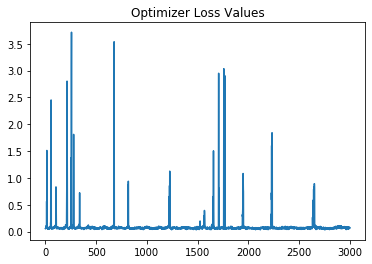

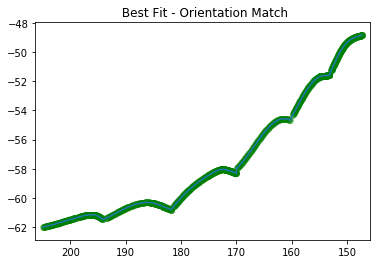

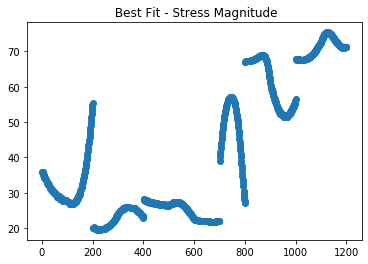

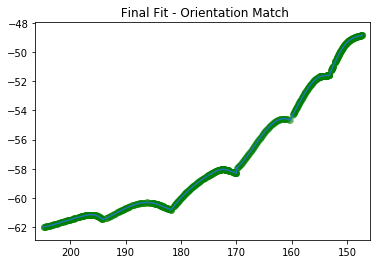

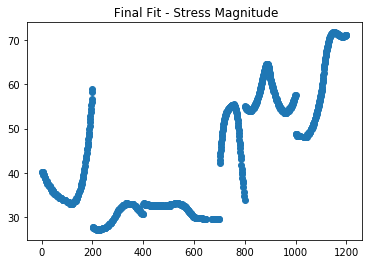

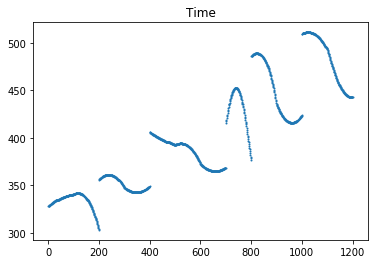

In [5]:
process_cycloid(cycloids['cilicia'].curve, 'cilicia', folder='./output/', iterations=3000, constraints=constraints)

Iteration 50/3000 -- Loss Output: 0.059036214745609494 -- Moving Avg Loss: 0.0567622962383761
	Parameters used: [0.26459414 0.31955514]
Iteration 100/3000 -- Loss Output: 0.05710125438349635 -- Moving Avg Loss: 0.06596485929045592
	Parameters used: [0.20807513 0.26303614]
Iteration 150/3000 -- Loss Output: 0.2196494834084485 -- Moving Avg Loss: 11.21399172756483
	Parameters used: [0.46353747 0.38644644]
Iteration 200/3000 -- Loss Output: 0.07484683423444645 -- Moving Avg Loss: 0.07412942382015689
	Parameters used: [0.19585541 0.11876163]
Iteration 250/3000 -- Loss Output: 0.08017941791058346 -- Moving Avg Loss: 0.08087530496808887
	Parameters used: [0.156639   0.07954478]
Iteration 300/3000 -- Loss Output: 0.1209585682075855 -- Moving Avg Loss: 0.10126635522449996
	Parameters used: [0.10580767 0.02871289]
Iteration 350/3000 -- Loss Output: 0.09692802401107607 -- Moving Avg Loss: 0.09252774685609857
	Parameters used: [0.04727569 0.63687641]
Iteration 400/3000 -- Loss Output: 0.217218684

{'loss': 0.0372329726312247, 'parameters': array([0.21209679, 0.50879323])}

{'loss': 0.20958341061768418, 'parameters': array([0.59006913, 0.04084733])}

[76.35484582  0.55791391]
[2.12424886e+02 1.36762598e-01]


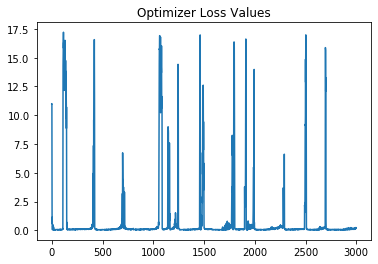

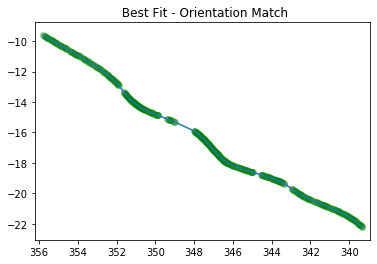

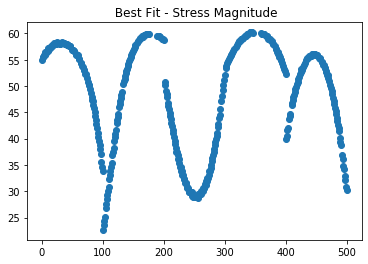

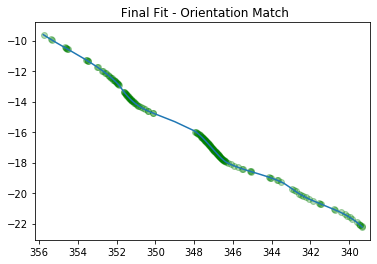

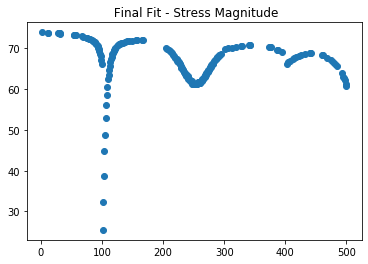

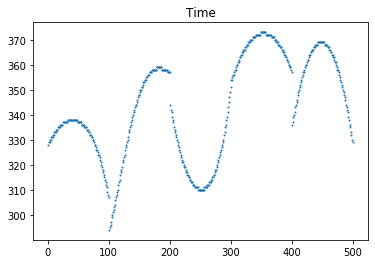

In [9]:
process_cycloid(cycloids['yaphet'].curve, 'yaphet', folder='./output/', iterations=3000, constraints=constraints)

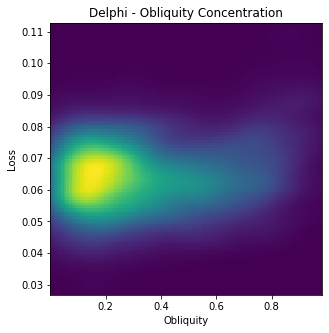

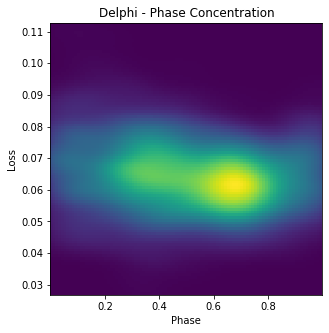

In [7]:
fitting.optimizationHeatMap(opt, 'Delphi')

(array([317., 422., 320., 236., 169., 159., 132., 124.,  83.,  38.]),
 array([4.39462573e-05, 9.83365008e-02, 1.96629055e-01, 2.94921610e-01,
        3.93214164e-01, 4.91506719e-01, 5.89799274e-01, 6.88091828e-01,
        7.86384383e-01, 8.84676937e-01, 9.82969492e-01]),
 <a list of 10 Patch objects>)

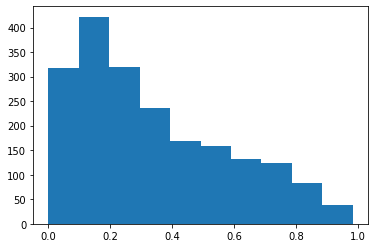

In [8]:
obliquity = opt[3].T[2]

plt.hist(obliquity)

100

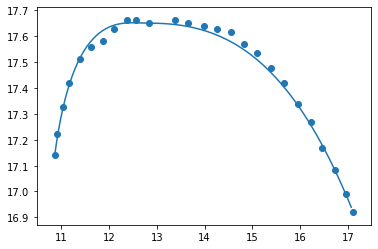

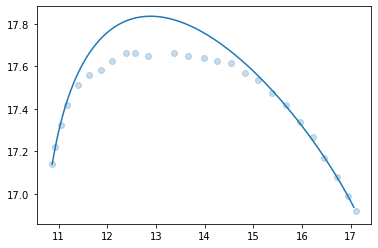

In [25]:
arcPoints = cycloids['alex'].arcs[0]
arc = cycloids['alex'].curve[0:200]

plt.plot(arc['lon'], arc['lat'])
plt.scatter(arcPoints['lon'], arcPoints['lat'])
plt.figure()

plt.scatter(arcPoints['lon'], arcPoints['lat'], alpha=0.25)
testFit = fitting.fit_arc(arcPoints, max_error=0.09)
plt.plot(testFit['lon'], testFit['lat'])

display(len(testFit))

plgt.
arcPoints = cycloids['alex'].arcs[0]
arc = cycloids['alex'].curve[0:200]

plt.plot(arc['lon'], arc['lat'])
plt.scatter(arcPoints['lon'], arcPoints['lat'])
plt.figure()

plt.scatter(arcPoints['lon'], arcPoints['lat'], alpha=0.25)
testFit = fitting.fit_arc(arcPoints, max_error=0.09)
plt.plot(testFit['lon'], testFit['lat'])

display(len(testFit))

In [16]:
cycloids['alex'].curve.loc[cycloids['alex'].curve['isCusp']]

,pointNumber,lon,lat,heading,headingCategory,isCusp
0,1,10.867000,17.140000,215.604534,216.0,True
199,200,17.064953,16.938717,294.322091,294.0,True
200,201,17.304000,17.094000,237.714558,238.0,True
399,400,24.343219,15.663298,294.465194,294.0,True
400,401,24.495000,15.827000,239.521416,240.0,True
599,600,32.093370,13.253879,312.493721,312.0,True
